# Text classification with different neural network architectures

## Michał Gromadzki

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import re
import string
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
tf.random.set_seed(1337)
np.random.seed(1337)

In [2]:
#https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification
data = pd.read_csv('data/Corona_NLP_train.csv', encoding='latin-1')
data_test = pd.read_csv('data/Corona_NLP_test.csv', encoding='latin-1')
data

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


## Preprocessing

In [3]:
len(data)

41157

In [4]:
data_val = data[int(0.8*len(data)):]
data_train = data[:int(0.8*len(data))]

In [5]:
data_train.shape, data_val.shape, data_test.shape

((32925, 6), (8232, 6), (3798, 6))

In [6]:
stopwords = stopwords.words('english')

In [7]:
def preprocess(text):
    text = text.lower() #converting input to lowercase
    text = re.sub(r'\([^)]*\)', '', text) #Removing punctuations and special characters.
    text = re.sub('"','', text) #Removing double quotes.
    text = re.sub(r"'s\b","",text) #Eliminating apostrophe.
    text = re.sub(r"@[A-Za-z0-9_]+", "", text) #Removing twitter handles
    text = re.sub("[^a-zA-Z]", " ", text) #Removing non-alphabetical characters
    text = ' '.join([word for word in text.split() if word not in stopwords]) #Removing stopwords.
    return text

In [8]:
clean_text_train = [preprocess(text) for text in data_train["OriginalTweet"].values]
clean_text_val = [preprocess(text) for text in data_val["OriginalTweet"].values]
clean_text_test = [preprocess(text) for text in data_test["OriginalTweet"].values]

In [9]:
Sentiment = np.unique(data.Sentiment.values)

In [10]:
stoi = {i:s for s,i in enumerate(Sentiment)}
stoi

{'Extremely Negative': 0,
 'Extremely Positive': 1,
 'Negative': 2,
 'Neutral': 3,
 'Positive': 4}

In [11]:
itos = { i:ch for i,ch in enumerate(Sentiment)}

In [12]:
encode = lambda s: [stoi[i] for i in s]
decode = lambda l: itos[l]

In [13]:
labels_train = encode(data_train.Sentiment.values)
labels_val = encode(data_val.Sentiment.values)
labels_test = encode(data_test.Sentiment.values)

In [14]:
vocab_size = 2048
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(clean_text_train)
x_train_seq = tokenizer.texts_to_sequences(clean_text_train)
x_val_seq = tokenizer.texts_to_sequences(clean_text_val)
x_test_seq = tokenizer.texts_to_sequences(clean_text_test)

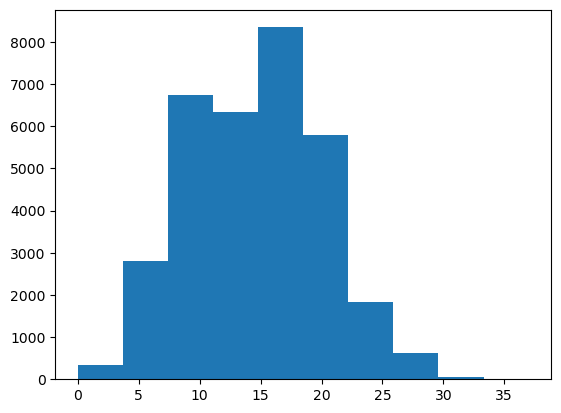

In [15]:
plt.hist([len(seq) for seq in x_train_seq])
plt.show()

In [16]:
np.quantile([len(seq) for seq in x_train_seq],0.95)

24.0

In [17]:
np.max([len(seq) for seq in x_train_seq])

37

In [18]:
max_len = 32
vocab_size = len(tokenizer.word_index) + 1
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_val_pad = pad_sequences(x_val_seq, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post')

In [19]:
labels_train = np.array(labels_train)
labels_val = np.array(labels_val)
labels_test = np.array(labels_test)

In [20]:
labels_train = np.reshape(labels_train, (len(labels_train),1))
labels_val = np.reshape(labels_val, (len(labels_val),1))
labels_test = np.reshape(labels_test, (len(labels_test),1))

## Models

### Baseline

In [130]:
#No embedding
model = tf.keras.Sequential([
    tf.keras.layers.Dense(max_len, activation='relu'),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Softmax(),
])

In [131]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [132]:
model.fit(x_train_pad, labels_train, epochs=10, batch_size=32, validation_data=(x_val_pad, labels_val))

Epoch 1/10
1029/1029 [==============================] - 5s 4ms/step - loss: 31.9243 - accuracy: 0.2218 - val_loss: 7.4622 - val_accuracy: 0.2212
Epoch 2/10
1029/1029 [==============================] - 4s 4ms/step - loss: 3.8931 - accuracy: 0.2350 - val_loss: 2.2629 - val_accuracy: 0.2451
Epoch 3/10
1029/1029 [==============================] - 4s 4ms/step - loss: 2.2623 - accuracy: 0.2475 - val_loss: 1.9824 - val_accuracy: 0.2799
Epoch 4/10
1029/1029 [==============================] - 4s 4ms/step - loss: 2.0941 - accuracy: 0.2482 - val_loss: 1.9942 - val_accuracy: 0.2004
Epoch 5/10
1029/1029 [==============================] - 4s 4ms/step - loss: 1.9951 - accuracy: 0.2549 - val_loss: 1.8309 - val_accuracy: 0.2802
Epoch 6/10
1029/1029 [==============================] - 4s 4ms/step - loss: 1.9856 - accuracy: 0.2536 - val_loss: 1.7384 - val_accuracy: 0.2496
Epoch 7/10
1029/1029 [==============================] - 4s 4ms/step - loss: 1.9711 - accuracy: 0.2558 - val_loss: 2.2864 - val_accuracy

In [133]:
loss, acc = model.evaluate(x_test_pad, labels_test)
acc

119/119 [==============================] - 1s 6ms/step - loss: 2.0360 - accuracy: 0.2578


0.2577672600746155

### Dense - small

In [134]:
n_embed = 4
batch_size = 32

In [135]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, n_embed,input_length=max_len),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(max_len * n_embed, activation='relu'),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Softmax(),
])

In [136]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 32, 4)             236612    
                                                                 
 flatten_14 (Flatten)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 5)                 645       
                                                                 
 softmax_16 (Softmax)        (None, 5)                 0         
                                                                 
Total params: 253,769
Trainable params: 253,769
Non-trainable params: 0
_________________________________________________________________


In [137]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [138]:
model.fit(x_train_pad, labels_train, epochs=10, batch_size=32, validation_data=(x_val_pad, labels_val))

Epoch 1/10
1029/1029 [==============================] - 11s 10ms/step - loss: 1.3203 - accuracy: 0.4311 - val_loss: 1.1122 - val_accuracy: 0.5647
Epoch 2/10
1029/1029 [==============================] - 8s 7ms/step - loss: 1.0827 - accuracy: 0.5770 - val_loss: 1.0590 - val_accuracy: 0.5943
Epoch 3/10
1029/1029 [==============================] - 5s 5ms/step - loss: 1.0442 - accuracy: 0.5969 - val_loss: 1.0463 - val_accuracy: 0.5975
Epoch 4/10
1029/1029 [==============================] - 6s 6ms/step - loss: 1.0213 - accuracy: 0.6046 - val_loss: 1.0547 - val_accuracy: 0.5911
Epoch 5/10
1029/1029 [==============================] - 6s 6ms/step - loss: 1.0050 - accuracy: 0.6125 - val_loss: 1.0521 - val_accuracy: 0.5968
Epoch 6/10
1029/1029 [==============================] - 5s 5ms/step - loss: 0.9909 - accuracy: 0.6185 - val_loss: 1.0502 - val_accuracy: 0.5983
Epoch 7/10
1029/1029 [==============================] - 6s 6ms/step - loss: 0.9815 - accuracy: 0.6212 - val_loss: 1.0549 - val_accurac

In [139]:
loss, acc = model.evaluate(x_test_pad, labels_test)
acc

119/119 [==============================] - 0s 3ms/step - loss: 1.1566 - accuracy: 0.5477


0.5476566553115845

### Dense - large

In [140]:
n_embed = 16
batch_size = 32

In [141]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, n_embed,input_length=max_len),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(max_len * n_embed, activation='relu'),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Softmax(),
])

In [142]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 32, 16)            946448    
                                                                 
 flatten_15 (Flatten)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 512)               262656    
                                                                 
 dense_20 (Dense)            (None, 64)                32832     
                                                                 
 dense_21 (Dense)            (None, 5)                 325       
                                                                 
 softmax_17 (Softmax)        (None, 5)                 0         
                                                                 
Total params: 1,242,261
Trainable params: 1,242,261
N

In [143]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [144]:
model.fit(x_train_pad, labels_train, epochs=10, batch_size=32, validation_data=(x_val_pad, labels_val))

Epoch 1/10
1029/1029 [==============================] - 10s 10ms/step - loss: 1.2312 - accuracy: 0.4834 - val_loss: 1.0658 - val_accuracy: 0.5914
Epoch 2/10
1029/1029 [==============================] - 20s 19ms/step - loss: 1.0321 - accuracy: 0.5979 - val_loss: 1.0562 - val_accuracy: 0.5831
Epoch 3/10
1029/1029 [==============================] - 18s 18ms/step - loss: 0.9551 - accuracy: 0.6320 - val_loss: 1.0866 - val_accuracy: 0.5735
Epoch 4/10
1029/1029 [==============================] - 17s 16ms/step - loss: 0.8678 - accuracy: 0.6730 - val_loss: 1.1483 - val_accuracy: 0.5613
Epoch 5/10
1029/1029 [==============================] - 9s 9ms/step - loss: 0.7670 - accuracy: 0.7184 - val_loss: 1.2340 - val_accuracy: 0.5590
Epoch 6/10
1029/1029 [==============================] - 10s 10ms/step - loss: 0.6517 - accuracy: 0.7646 - val_loss: 1.3718 - val_accuracy: 0.5483
Epoch 7/10
1029/1029 [==============================] - 24s 23ms/step - loss: 0.5297 - accuracy: 0.8117 - val_loss: 1.6249 - v

In [145]:
loss, acc = model.evaluate(x_test_pad, labels_test)
acc

119/119 [==============================] - 1s 7ms/step - loss: 2.7646 - accuracy: 0.4663


0.46629804372787476

### RNN

In [146]:
n_embed = 4
batch_size = 32

In [147]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, n_embed,input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(max_len * n_embed, return_sequences=True)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Softmax(),
])

In [148]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 32, 4)             236612    
                                                                 
 bidirectional_15 (Bidirecti  (None, 32, 256)          34048     
 onal)                                                           
                                                                 
 flatten_16 (Flatten)        (None, 8192)              0         
                                                                 
 dense_22 (Dense)            (None, 5)                 40965     
                                                                 
 softmax_18 (Softmax)        (None, 5)                 0         
                                                                 
Total params: 311,625
Trainable params: 311,625
Non-trainable params: 0
_______________________________________________

In [149]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [150]:
model.fit(x_train_pad, labels_train, epochs=10, batch_size=32, validation_data=(x_val_pad, labels_val))

Epoch 1/10
1029/1029 [==============================] - 132s 126ms/step - loss: 1.2847 - accuracy: 0.4528 - val_loss: 1.1086 - val_accuracy: 0.5694
Epoch 2/10
1029/1029 [==============================] - 137s 133ms/step - loss: 1.1138 - accuracy: 0.5577 - val_loss: 1.0889 - val_accuracy: 0.5836
Epoch 3/10
1029/1029 [==============================] - 120s 117ms/step - loss: 1.0915 - accuracy: 0.5708 - val_loss: 1.0822 - val_accuracy: 0.5799
Epoch 4/10
1029/1029 [==============================] - 134s 131ms/step - loss: 1.0787 - accuracy: 0.5820 - val_loss: 1.0872 - val_accuracy: 0.5764
Epoch 5/10
1029/1029 [==============================] - 144s 140ms/step - loss: 1.0686 - accuracy: 0.5828 - val_loss: 1.0947 - val_accuracy: 0.5779
Epoch 6/10
1029/1029 [==============================] - 159s 155ms/step - loss: 1.0585 - accuracy: 0.5893 - val_loss: 1.0810 - val_accuracy: 0.5838
Epoch 7/10
1029/1029 [==============================] - 159s 154ms/step - loss: 1.0518 - accuracy: 0.5925 - val_

In [151]:
loss, acc = model.evaluate(x_test_pad, labels_test)
acc

119/119 [==============================] - 2s 16ms/step - loss: 1.1974 - accuracy: 0.5250


0.5250131487846375

### GRU

In [152]:
n_embed = 4
batch_size = 32

In [153]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, n_embed,input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(max_len * n_embed,return_sequences=True)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Softmax(),
])

In [154]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 32, 4)             236612    
                                                                 
 bidirectional_16 (Bidirecti  (None, 32, 256)          102912    
 onal)                                                           
                                                                 
 flatten_17 (Flatten)        (None, 8192)              0         
                                                                 
 dense_23 (Dense)            (None, 5)                 40965     
                                                                 
 softmax_19 (Softmax)        (None, 5)                 0         
                                                                 
Total params: 380,489
Trainable params: 380,489
Non-trainable params: 0
_______________________________________________

In [155]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [156]:
model.fit(x_train_pad, labels_train, epochs=10, batch_size=32, validation_data=(x_val_pad, labels_val))

Epoch 1/10
1029/1029 [==============================] - 30s 25ms/step - loss: 1.2541 - accuracy: 0.4733 - val_loss: 1.0705 - val_accuracy: 0.5907
Epoch 2/10
1029/1029 [==============================] - 31s 30ms/step - loss: 1.0842 - accuracy: 0.5805 - val_loss: 1.0612 - val_accuracy: 0.5897
Epoch 3/10
1029/1029 [==============================] - 29s 28ms/step - loss: 1.0630 - accuracy: 0.5874 - val_loss: 1.0468 - val_accuracy: 0.5968
Epoch 4/10
1029/1029 [==============================] - 24s 24ms/step - loss: 1.0444 - accuracy: 0.5957 - val_loss: 1.0470 - val_accuracy: 0.5984
Epoch 5/10
1029/1029 [==============================] - 28s 27ms/step - loss: 1.0275 - accuracy: 0.5973 - val_loss: 1.0461 - val_accuracy: 0.6101
Epoch 6/10
1029/1029 [==============================] - 28s 28ms/step - loss: 1.0127 - accuracy: 0.6058 - val_loss: 1.0410 - val_accuracy: 0.6016
Epoch 7/10
1029/1029 [==============================] - 28s 27ms/step - loss: 1.0021 - accuracy: 0.6085 - val_loss: 1.0626 -

In [157]:
loss, acc = model.evaluate(x_test_pad, labels_test)
acc

119/119 [==============================] - 1s 8ms/step - loss: 1.1707 - accuracy: 0.5411


0.541074275970459

### LSTM

In [158]:
n_embed = 4
batch_size = 32

In [159]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, n_embed,input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(max_len * n_embed,return_sequences=True)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Softmax(),
])

In [160]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 32, 4)             236612    
                                                                 
 bidirectional_17 (Bidirecti  (None, 32, 256)          136192    
 onal)                                                           
                                                                 
 flatten_18 (Flatten)        (None, 8192)              0         
                                                                 
 dense_24 (Dense)            (None, 5)                 40965     
                                                                 
 softmax_20 (Softmax)        (None, 5)                 0         
                                                                 
Total params: 413,769
Trainable params: 413,769
Non-trainable params: 0
_______________________________________________

In [161]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [162]:
model.fit(x_train_pad, labels_train, epochs=10, batch_size=32, validation_data=(x_val_pad, labels_val))

Epoch 1/10
1029/1029 [==============================] - 28s 24ms/step - loss: 1.3009 - accuracy: 0.4494 - val_loss: 1.0905 - val_accuracy: 0.5788
Epoch 2/10
1029/1029 [==============================] - 23s 22ms/step - loss: 1.0918 - accuracy: 0.5726 - val_loss: 1.0613 - val_accuracy: 0.5914
Epoch 3/10
1029/1029 [==============================] - 22s 22ms/step - loss: 1.0638 - accuracy: 0.5862 - val_loss: 1.0384 - val_accuracy: 0.6018
Epoch 4/10
1029/1029 [==============================] - 22s 22ms/step - loss: 1.0488 - accuracy: 0.5963 - val_loss: 1.0418 - val_accuracy: 0.5978
Epoch 5/10
1029/1029 [==============================] - 24s 23ms/step - loss: 1.0367 - accuracy: 0.5994 - val_loss: 1.0392 - val_accuracy: 0.6080
Epoch 6/10
1029/1029 [==============================] - 30s 30ms/step - loss: 1.0244 - accuracy: 0.6056 - val_loss: 1.0267 - val_accuracy: 0.6080
Epoch 7/10
1029/1029 [==============================] - 31s 30ms/step - loss: 1.0144 - accuracy: 0.6068 - val_loss: 1.0441 -

In [163]:
loss, acc = model.evaluate(x_test_pad, labels_test)
acc

119/119 [==============================] - 1s 9ms/step - loss: 1.1566 - accuracy: 0.5513


0.551342785358429

### Conv - small

In [164]:
n_embed = 4
batch_size = 32

In [165]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, n_embed,input_length=max_len),
    tf.keras.layers.Conv1D(max_len * n_embed,n_embed * 4,padding="same"),  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Softmax(),
])

In [166]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 32, 4)             236612    
                                                                 
 conv1d (Conv1D)             (None, 32, 128)           8320      
                                                                 
 flatten_19 (Flatten)        (None, 4096)              0         
                                                                 
 dense_25 (Dense)            (None, 5)                 20485     
                                                                 
 softmax_21 (Softmax)        (None, 5)                 0         
                                                                 
Total params: 265,417
Trainable params: 265,417
Non-trainable params: 0
_________________________________________________________________


In [167]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [168]:
model.fit(x_train_pad, labels_train, epochs=10, batch_size=32, validation_data=(x_val_pad, labels_val))

Epoch 1/10
1029/1029 [==============================] - 17s 11ms/step - loss: 1.2459 - accuracy: 0.4795 - val_loss: 1.0924 - val_accuracy: 0.5810
Epoch 2/10
1029/1029 [==============================] - 11s 11ms/step - loss: 1.0968 - accuracy: 0.5726 - val_loss: 1.0769 - val_accuracy: 0.5909
Epoch 3/10
1029/1029 [==============================] - 10s 10ms/step - loss: 1.0798 - accuracy: 0.5828 - val_loss: 1.0773 - val_accuracy: 0.5844
Epoch 4/10
1029/1029 [==============================] - 10s 10ms/step - loss: 1.0661 - accuracy: 0.5896 - val_loss: 1.0925 - val_accuracy: 0.5753
Epoch 5/10
1029/1029 [==============================] - 10s 10ms/step - loss: 1.0551 - accuracy: 0.5925 - val_loss: 1.0995 - val_accuracy: 0.5788
Epoch 6/10
1029/1029 [==============================] - 11s 11ms/step - loss: 1.0469 - accuracy: 0.5954 - val_loss: 1.0894 - val_accuracy: 0.5831
Epoch 7/10
1029/1029 [==============================] - 12s 12ms/step - loss: 1.0432 - accuracy: 0.5996 - val_loss: 1.0936 -

In [169]:
loss, acc = model.evaluate(x_test_pad, labels_test)
acc

119/119 [==============================] - 1s 6ms/step - loss: 1.1924 - accuracy: 0.5258


0.5258030295372009

### Conv - large

In [170]:
n_embed = 16
batch_size = 32

In [171]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, n_embed,input_length=max_len),
    tf.keras.layers.Conv1D(max_len * n_embed,n_embed*4,padding="same"),  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Softmax(),
])

In [172]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 32, 16)            946448    
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 512)           524800    
                                                                 
 flatten_20 (Flatten)        (None, 16384)             0         
                                                                 
 dense_26 (Dense)            (None, 5)                 81925     
                                                                 
 softmax_22 (Softmax)        (None, 5)                 0         
                                                                 
Total params: 1,553,173
Trainable params: 1,553,173
Non-trainable params: 0
_________________________________________________________________


In [173]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [174]:
model.fit(x_train_pad, labels_train, epochs=10, batch_size=32, validation_data=(x_val_pad, labels_val))

Epoch 1/10
1029/1029 [==============================] - 43s 38ms/step - loss: 1.2355 - accuracy: 0.4839 - val_loss: 1.1101 - val_accuracy: 0.5610
Epoch 2/10
1029/1029 [==============================] - 31s 30ms/step - loss: 1.1081 - accuracy: 0.5597 - val_loss: 1.1027 - val_accuracy: 0.5711
Epoch 3/10
1029/1029 [==============================] - 35s 34ms/step - loss: 1.0687 - accuracy: 0.5764 - val_loss: 1.1257 - val_accuracy: 0.5452
Epoch 4/10
1029/1029 [==============================] - 30s 29ms/step - loss: 1.0320 - accuracy: 0.5963 - val_loss: 1.1523 - val_accuracy: 0.5390
Epoch 5/10
1029/1029 [==============================] - 20s 20ms/step - loss: 0.9964 - accuracy: 0.6121 - val_loss: 1.2047 - val_accuracy: 0.5369
Epoch 6/10
1029/1029 [==============================] - 26s 25ms/step - loss: 0.9654 - accuracy: 0.6250 - val_loss: 1.1942 - val_accuracy: 0.5425
Epoch 7/10
1029/1029 [==============================] - 28s 27ms/step - loss: 0.9404 - accuracy: 0.6354 - val_loss: 1.2350 -

In [175]:
loss, acc = model.evaluate(x_test_pad, labels_test)
acc

119/119 [==============================] - 3s 26ms/step - loss: 1.4447 - accuracy: 0.4679


0.4678778350353241

### Bigger model

In [21]:
n_embed = 32
batch_size = 32

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, n_embed,input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Softmax(),
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 32)            1892896   
                                                                 
 bidirectional (Bidirectiona  (None, 32, 256)          164864    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
 softmax (Softmax)           (None, 5)                 0

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [25]:
model.fit(x_train_pad, labels_train, epochs=7, batch_size=256, validation_data=(x_val_pad, labels_val))

Epoch 1/7
129/129 [==============================] - 16s 47ms/step - loss: 1.3965 - accuracy: 0.3835 - val_loss: 1.1458 - val_accuracy: 0.5307
Epoch 2/7
129/129 [==============================] - 4s 35ms/step - loss: 1.0030 - accuracy: 0.6119 - val_loss: 0.9318 - val_accuracy: 0.6545
Epoch 3/7
129/129 [==============================] - 5s 35ms/step - loss: 0.9082 - accuracy: 0.6651 - val_loss: 0.9160 - val_accuracy: 0.6725
Epoch 4/7
129/129 [==============================] - 5s 38ms/step - loss: 0.8790 - accuracy: 0.6832 - val_loss: 0.9192 - val_accuracy: 0.6656
Epoch 5/7
129/129 [==============================] - 5s 36ms/step - loss: 0.8607 - accuracy: 0.6939 - val_loss: 0.9247 - val_accuracy: 0.6652
Epoch 6/7
129/129 [==============================] - 4s 34ms/step - loss: 0.8433 - accuracy: 0.6998 - val_loss: 0.9216 - val_accuracy: 0.6655
Epoch 7/7
129/129 [==============================] - 4s 34ms/step - loss: 0.8308 - accuracy: 0.7062 - val_loss: 0.9284 - val_accuracy: 0.6673


In [26]:
loss, acc = model.evaluate(x_test_pad, labels_test)
acc

119/119 [==============================] - 2s 13ms/step - loss: 1.0143 - accuracy: 0.6195


0.6195365786552429

## Test the model

In [27]:
choices = np.random.choice(data_test["OriginalTweet"].values,10)
choices_vec = tokenizer.texts_to_sequences(choices)
choices_vec = pad_sequences(choices_vec, maxlen=max_len, padding='post')
preds = model.predict(choices_vec, verbose=0)
for choice,pred in zip(choices,preds):
    print(choice)
    print(f"Sentiment: {decode(np.argmax(pred))}")
    print("-" * 200)

Just got back from the grocery store. Still no hand sanitizer or hand soap, limited TP. But bottled water and bread were full. Vibe was like any other Sunday. #coronavirus #panicshopping #StayCalm
Sentiment: Extremely Positive
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
People. If you are coughing or feeling sick stay at home. Do not go to the grocery store. Do not go to work. Please. This would be over if you just did that. #COVID19 #coronavirus #Pandumbic
Sentiment: Negative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
More than 4.4 million Canadians say they feel food insecure due to financial constraints: report https://t.co/3GPXCThrNM https://t.co/t507X4oG9k
Sentiment: Neut

### Final model in model.py